In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from glob import glob
import os

from sklearn.preprocessing import StandardScaler

from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns

import pickle
import time
from tqdm import tqdm
from sklearn import metrics
from sklearn import model_selection as ms
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier


from rerf.rerfClassifier import rerfClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import average_precision_score

import warnings
warnings.simplefilter('ignore')

In [5]:
def prepare_data_train(fname_d,fname_e):
    """ read and prepare training data """
    # Read data
    data = pd.read_csv(fname_d)
    # events file
    #events_fname = fname.replace('_data','_events')
    # read event file
    labels= pd.read_csv(fname_e)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels


def prepare_data_test(fname):
    """ read and prepare test data """
    # Read data
    data = pd.read_csv(fname)
    return data

scaler= StandardScaler()
def data_preprocess_train(X):
    X_prep=scaler.fit_transform(X)
    #do here your preprocessing
    return X_prep
def data_preprocess_test(X):
    X_prep=scaler.transform(X)
    #do here your preprocessing
    return X_prep

In [107]:
#######columns name for labels#############
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']

#######number of subjects###############
subjects = range(1,10)
ids_tot = []
pred_tot = []
X = []
Y = []
###loop on subjects and 8 series for train data + 2 series for test data
for subject in subjects:
    y_raw= []
    raw = []
    ################ READ DATA ################################################
    for i in range(1,9):
        fname_d =  '/media/ubuntu/DATA/UbuntuFiles/EEG_dataset/train/subj' + '%d' % (subject) + '_series' + '%d' '_data.csv' % (i)
        fname_e =  '/media/ubuntu/DATA/UbuntuFiles/EEG_dataset/train/subj' + '%d' % (subject) + '_series' + '%d' '_events.csv' % (i)
        data,labels=prepare_data_train(fname_d,fname_e)
        raw.append(data)
        y_raw.append(labels)
        

    X = pd.concat(raw)
    y = pd.concat(y_raw)
    #print (length(X))
    #print (length(y))
    #transform in numpy array
    #transform train data in numpy array
    X_train =np.asarray(X.astype(float))
    Y_train = np.asarray(y.astype(float))
    

    
######Preparing test data#####################
subjects = range(11,12)
ids_tot = []
pred_tot = []
X_t = []
y_t = []
###loop on subjects and 8 series for train data + 2 series for test data
for subject in subjects:
    y_raw_t= []
    raw_t = []
    ################ READ DATA ################################################
    for i in range(1,3):
        fname_d =  '/media/ubuntu/DATA/UbuntuFiles/EEG_dataset/train/subj' + '%d' % (subject) + '_series' + '%d' '_data.csv' % (i)
        fname_e =  '/media/ubuntu/DATA/UbuntuFiles/EEG_dataset/train/subj' + '%d' % (subject) + '_series' + '%d' '_events.csv' % (i)
        dt,lb=prepare_data_train(fname_d,fname_e)
        raw_t.append(dt)
        y_raw_t.append(lb)
        

    X_t = pd.concat(raw_t)
    y_t = pd.concat(y_raw_t)
    #print (length(X))
    #print (length(y))
    #transform in numpy array
    #transform train data in numpy array
    X_test =np.asarray(X_t.astype(float))
    Y_test = np.asarray(y_t.astype(float))

In [91]:
print(X_train.shape)

(1447494, 32)


Time binning: the data is split into smaller segments of lenght 5 sec. The windows are overlapping.
for each time bin there is a single Y output for the action "grasp" (third column of 'y')
The time binning for only one channel (channel 5) is used for training.

In [108]:
segment_len = 5
slide_len = 2
shuff_seg = []
shuff_y = []
segments = X_train
seg_y = Y_train
for start_pos in range(0, len(segments), slide_len):
    end_pos = start_pos + segment_len
    # make a copy of segment
    segment = segments[start_pos:end_pos,:]
    y_seg = np.max(seg_y[start_pos:end_pos],axis = 0)
    # if we're at the end and we've got a truncated segment, drop it
    if len(segment) != segment_len:
        break
    shuff_seg.append(segment)
    shuff_y.append(y_seg)

shuff_seg = np.asarray(shuff_seg)
shuff_y = np.asarray(shuff_y)

print(shuff_seg.shape,shuff_y.shape)
#selecting channel
X_train_ch = shuff_seg[:,:,5]
#Y-values for grasp
Y_train_ch = shuff_y[:,3]
X_train_ch.shape

(723745, 5, 32) (723745, 6)


(723745, 5)

In [6]:
#plotting one segment in the binned series for testing
plt.plot(range(1,5),X_train[90:95,5])
plt.figure()
plt.plot(range(1,5),X_train_ch[18:19,:].transpose())

NameError: name 'X_train' is not defined

Time binning for test data

In [109]:
segment_len = 5
slide_len = 2
shuff_seg_ts = []
shuff_y_ts = []
segments_ts = X_test
seg_y_ts = Y_test
for start_pos in range(0, len(segments_ts), slide_len):
    end_pos = start_pos + segment_len
    # make a copy so changes to 'segments' doesn't modify the original ekg_data
    segment_ts = segments_ts[start_pos:end_pos]
    y_seg_ts = np.max(seg_y_ts[start_pos:end_pos],axis = 0)
    # if we're at the end and we've got a truncated segment, drop it
    if len(segment_ts) != segment_len:
        continue
    shuff_seg_ts.append(segment_ts)
    shuff_y_ts.append(y_seg_ts)

shuff_seg_ts = np.asarray(shuff_seg_ts)
shuff_y_ts = np.asarray(shuff_y_ts)

print(shuff_seg_ts.shape,shuff_y_ts.shape)
X_test_ch = shuff_seg_ts[:,:,5]
Y_test_ch = shuff_y_ts[:,3]
X_test_ch.shape

(185547, 5, 32) (185547, 6)


(185547, 5)

Normalising training data

In [110]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_ch = sc.fit_transform(X_train_ch)
X_test_ch = sc.fit_transform(X_test_ch)


X_train =np.asarray(X_train_ch.astype(float))
Y_train = np.asarray(Y_train_ch.astype(float))

X_test =np.asarray(X_test_ch.astype(float))
Y_test = np.asarray(Y_test_ch.astype(float))

print(len(X_test))
print(X_train.shape)

185547
(723745, 5)


Down-sampling and balancing data so that the classifiers get the samples from both the classes.

In [121]:
#locating samples which give positive results and splitting them
act_idx = np.where(Y_train == 1)
act_dat = X_train[act_idx]
act_y = Y_train[act_idx]
#splitting to samples which give negative results
non_act_dat = np.delete(X_train,act_idx,axis=0)
non_act_y = np.delete(Y_train,act_idx,axis=0)
#balancing data and reducing the negative results to three times the positive ones
idx = np.random.choice(np.arange(len(non_act_dat)),3*len(act_dat), replace=True)
non_act = non_act_dat[idx]
y_non_act = non_act_y[idx]

X_train_downsampled = np.concatenate((act_dat,non_act),axis=0)
Y_train_downsampled = np.concatenate((act_y,y_non_act),axis=0)

print(X_train_downsampled.shape,Y_train_downsampled.shape)

(80080, 5) (80080,)


Training of classifiers: Three iterations and data sampled for each iteration, training samples from 10 to 100000, average precision and mean test error recorded.


In [132]:
names = {"Log. Reg": "blue", "Lin. SVM":"firebrick", "SVM":"purple",
          "kNN": "black", "RF":"#f86000", "MLP":"green", "S-RerF":"red"}

ncores=1
num_runs=3
n_est=100

classifiers = [
    LogisticRegression(random_state=0, n_jobs=ncores, solver='liblinear'),
    LinearSVC(),
    SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(100, ), random_state=0, max_iter=1000),
    rerfClassifier(projection_matrix="S-RerF",
                   max_features=40,
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=1,
                    image_width=5,
                    patch_height_max=1,
                    patch_height_min=1,
                    patch_width_max=5,
                    patch_width_min=1
                   )
    ]

# Train each classifier on each data set size, then test
## Prep output file:
f = open('eeg_grasp_pre_lhat_onech_bin4.csv', 'w+')
f.write("classifier,n,Lhat,Precision,trainTime,testTime,iterate\n")
f.flush()

ns = np.array([10,500,5000,25000,50000,100000])
runList = [(clf) for clf in zip(classifiers, [key for key in names])]
for n in tqdm(ns):
    print (n)
    for iteration in tqdm(range(num_runs)):
        
        #sampling of data
        idx = np.random.choice(np.arange(len(X_train_downsampled)),n, replace=True)
        X = X_train_downsampled[idx]
        y = Y_train_downsampled[idx]
        
        idx_t = np.random.choice(np.arange(len(X_test)),int(len(X_test)/2), replace=True)
        X_test1 = X_test[idx_t]
        Y_test1 = Y_test[idx_t]
        
        print (iteration)
        for clf in tqdm(runList):
            
            #training
            trainStartTime = time.time()
            clf[0].fit(X, y)
            trainEndTime = time.time()
            trainTime = trainEndTime - trainStartTime
            #prediction
            testStartTime = time.time()
            out = clf[0].predict(X_test1)
            testEndTime = time.time()
            testTime = testEndTime - testStartTime
            #lhat error
            lhat = np.mean(np.not_equal(out, Y_test1).astype(int))
            #avg precision
            Y_test1 = np.asarray(Y_test1)
            out = np.asarray(out)
            y_val_true, val_pred = Y_test1.reshape((-1)), out.reshape((-1))
            avg_precision = average_precision_score(y_val_true, val_pred)

            #writing to file
            ####("variable,num of training samples,Lhat,avg precision,trainTime,testTime,iterate")
            f.write(f"{clf[1]}, {n}, {lhat:2.9f},{avg_precision:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
            f.flush()
f.close()




  0%|          | 0/6 [00:00<?, ?it/s]



  0%|          | 0/3 [00:00<?, ?it/s]




  0%|          | 0/7 [00:00<?, ?it/s]




 43%|████▎     | 3/7 [00:00<00:00, 17.70it/s]

10
0







 57%|█████▋    | 4/7 [00:01<00:01,  1.71it/s]




 71%|███████▏  | 5/7 [00:02<00:00,  2.02it/s]




 86%|████████▌ | 6/7 [00:02<00:00,  2.16it/s]




100%|██████████| 7/7 [00:02<00:00,  2.40it/s]




 33%|███▎      | 1/3 [00:02<00:05,  2.92s/it]




  0%|          | 0/7 [00:00<?, ?it/s]




 29%|██▊       | 2/7 [00:00<00:00, 17.93it/s]

1







 57%|█████▋    | 4/7 [00:02<00:00,  3.08it/s]




 71%|███████▏  | 5/7 [00:02<00:00,  2.97it/s]




 86%|████████▌ | 6/7 [00:02<00:00,  2.76it/s]




100%|██████████| 7/7 [00:03<00:00,  2.22it/s]




 67%|██████▋   | 2/3 [00:06<00:02,  2.99s/it]




  0%|          | 0/7 [00:00<?, ?it/s]




 29%|██▊       | 2/7 [00:00<00:00, 19.15it/s]

2







 43%|████▎     | 3/7 [00:00<00:00, 13.65it/s]




 57%|█████▋    | 4/7 [00:02<00:01,  1.68it/s]




 71%|███████▏  | 5/7 [00:02<00:01,  1.93it/s]




 86%|████████▌ | 6/7 [00:02<00:00,  2.04it/s]




100%|██████████| 7/7 [00:03<00:00,  2.17it/s]




100%|██████████| 3/3 [00:09<00:00,  3.11s/it]



 17%|█▋        | 1/6 [00:09<00:46,  9.32s/it]



  0%|          | 0/3 [00:00<?, ?it/s]




  0%|          | 0/7 [00:00<?, ?it/s]




 29%|██▊       | 2/7 [00:00<00:00, 12.57it/s]

500
0







 43%|████▎     | 3/7 [00:00<00:00,  4.18it/s]




 57%|█████▋    | 4/7 [00:02<00:02,  1.34it/s]




 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]




 86%|████████▌ | 6/7 [00:04<00:00,  1.42it/s]




100%|██████████| 7/7 [00:06<00:00,  1.02it/s]




 33%|███▎      | 1/3 [00:06<00:13,  6.88s/it]




  0%|          | 0/7 [00:00<?, ?it/s]

1







 43%|████▎     | 3/7 [00:00<00:01,  3.53it/s]




 57%|█████▋    | 4/7 [00:02<00:02,  1.23it/s]




 71%|███████▏  | 5/7 [00:03<00:01,  1.27it/s]




 86%|████████▌ | 6/7 [00:04<00:00,  1.50it/s]




100%|██████████| 7/7 [00:06<00:00,  1.00it/s]




 67%|██████▋   | 2/3 [00:13<00:06,  6.92s/it]




  0%|          | 0/7 [00:00<?, ?it/s]




 29%|██▊       | 2/7 [00:00<00:00, 14.86it/s]

2







 43%|████▎     | 3/7 [00:00<00:01,  3.84it/s]




 57%|█████▋    | 4/7 [00:02<00:02,  1.28it/s]




 71%|███████▏  | 5/7 [00:03<00:01,  1.35it/s]




 86%|████████▌ | 6/7 [00:03<00:00,  1.53it/s]




100%|██████████| 7/7 [00:06<00:00,  1.11it/s]




100%|██████████| 3/3 [00:20<00:00,  6.74s/it]



 33%|███▎      | 2/6 [00:29<00:50, 12.59s/it]



  0%|          | 0/3 [00:00<?, ?it/s]




  0%|          | 0/7 [00:00<?, ?it/s]

5000
0







 29%|██▊       | 2/7 [00:00<00:00,  5.94it/s]




 43%|████▎     | 3/7 [00:06<00:07,  1.92s/it]




 57%|█████▋    | 4/7 [00:08<00:06,  2.01s/it]




 71%|███████▏  | 5/7 [00:10<00:03,  1.86s/it]




 86%|████████▌ | 6/7 [00:12<00:01,  1.97s/it]




100%|██████████| 7/7 [00:35<00:00,  5.13s/it]




 33%|███▎      | 1/3 [00:35<01:11, 35.89s/it]




  0%|          | 0/7 [00:00<?, ?it/s]

1







 29%|██▊       | 2/7 [00:00<00:00,  5.29it/s]




 43%|████▎     | 3/7 [00:06<00:07,  1.87s/it]




 57%|█████▋    | 4/7 [00:08<00:06,  2.08s/it]




 71%|███████▏  | 5/7 [00:10<00:03,  1.98s/it]




 86%|████████▌ | 6/7 [00:12<00:02,  2.02s/it]




100%|██████████| 7/7 [00:37<00:00,  5.41s/it]




 67%|██████▋   | 2/3 [01:13<00:36, 36.48s/it]




  0%|          | 0/7 [00:00<?, ?it/s]

2







 29%|██▊       | 2/7 [00:00<00:00,  5.87it/s]




 43%|████▎     | 3/7 [00:05<00:06,  1.69s/it]




 57%|█████▋    | 4/7 [00:07<00:05,  1.82s/it]




 71%|███████▏  | 5/7 [00:09<00:03,  1.74s/it]




 86%|████████▌ | 6/7 [00:10<00:01,  1.64s/it]




100%|██████████| 7/7 [00:33<00:00,  4.84s/it]




100%|██████████| 3/3 [01:47<00:00, 35.87s/it]



 50%|█████     | 3/6 [02:17<02:03, 41.09s/it]



  0%|          | 0/3 [00:00<?, ?it/s]




  0%|          | 0/7 [00:00<?, ?it/s]

25000
0







 29%|██▊       | 2/7 [00:01<00:03,  1.66it/s]




 43%|████▎     | 3/7 [00:34<00:41, 10.45s/it]




 57%|█████▋    | 4/7 [00:37<00:24,  8.06s/it]




 71%|███████▏  | 5/7 [00:41<00:13,  6.92s/it]




 86%|████████▌ | 6/7 [00:54<00:08,  8.78s/it]




100%|██████████| 7/7 [02:58<00:00, 25.52s/it]




 33%|███▎      | 1/3 [02:58<05:57, 178.66s/it]




  0%|          | 0/7 [00:00<?, ?it/s]

1







 29%|██▊       | 2/7 [00:01<00:02,  1.74it/s]




 43%|████▎     | 3/7 [00:35<00:42, 10.57s/it]




 57%|█████▋    | 4/7 [00:37<00:24,  8.10s/it]




 71%|███████▏  | 5/7 [00:41<00:14,  7.02s/it]




 86%|████████▌ | 6/7 [00:48<00:07,  7.05s/it]




100%|██████████| 7/7 [03:11<00:00, 27.36s/it]




 67%|██████▋   | 2/3 [06:10<03:02, 182.53s/it]




  0%|          | 0/7 [00:00<?, ?it/s]

2







 29%|██▊       | 2/7 [00:01<00:03,  1.59it/s]




 43%|████▎     | 3/7 [00:36<00:43, 10.95s/it]




 57%|█████▋    | 4/7 [00:38<00:25,  8.38s/it]




 71%|███████▏  | 5/7 [00:43<00:14,  7.19s/it]




 86%|████████▌ | 6/7 [00:49<00:07,  7.05s/it]




100%|██████████| 7/7 [03:07<00:00, 26.82s/it]




100%|██████████| 3/3 [09:17<00:00, 185.99s/it]



 67%|██████▋   | 4/6 [11:35<06:32, 196.16s/it]



  0%|          | 0/3 [00:00<?, ?it/s]




  0%|          | 0/7 [00:00<?, ?it/s]

50000
0







 29%|██▊       | 2/7 [00:03<00:08,  1.71s/it]




 43%|████▎     | 3/7 [01:40<02:01, 30.34s/it]




 57%|█████▋    | 4/7 [01:43<01:06, 22.09s/it]




 71%|███████▏  | 5/7 [01:51<00:35, 17.90s/it]




 86%|████████▌ | 6/7 [02:09<00:17, 17.87s/it]




100%|██████████| 7/7 [06:35<00:00, 56.49s/it]




 33%|███▎      | 1/3 [06:35<13:10, 395.43s/it]




  0%|          | 0/7 [00:00<?, ?it/s]

1







 29%|██▊       | 2/7 [00:02<00:06,  1.25s/it]




 43%|████▎     | 3/7 [01:29<01:47, 26.93s/it]




 57%|█████▋    | 4/7 [01:31<00:58, 19.62s/it]




 71%|███████▏  | 5/7 [01:39<00:32, 16.08s/it]




 86%|████████▌ | 6/7 [01:51<00:14, 14.91s/it]




100%|██████████| 7/7 [06:35<00:00, 56.53s/it]




 67%|██████▋   | 2/3 [13:11<06:35, 395.52s/it]




  0%|          | 0/7 [00:00<?, ?it/s]

2







 29%|██▊       | 2/7 [00:02<00:06,  1.20s/it]




 43%|████▎     | 3/7 [01:28<01:46, 26.54s/it]




 57%|█████▋    | 4/7 [01:30<00:58, 19.36s/it]




 71%|███████▏  | 5/7 [01:38<00:31, 15.93s/it]




 86%|████████▌ | 6/7 [01:48<00:14, 14.03s/it]




100%|██████████| 7/7 [06:08<00:00, 52.71s/it]




100%|██████████| 3/3 [19:20<00:00, 386.71s/it]



 83%|████████▎ | 5/6 [30:55<08:05, 485.35s/it]



  0%|          | 0/3 [00:00<?, ?it/s]




  0%|          | 0/7 [00:00<?, ?it/s]




 14%|█▍        | 1/7 [00:00<00:00,  7.41it/s]

100000
0







 29%|██▊       | 2/7 [00:13<00:21,  4.20s/it]




 43%|████▎     | 3/7 [06:24<07:37, 114.29s/it]




 57%|█████▋    | 4/7 [06:27<04:02, 80.83s/it] 




 71%|███████▏  | 5/7 [06:42<02:01, 60.88s/it]




 86%|████████▌ | 6/7 [07:07<00:50, 50.11s/it]




100%|██████████| 7/7 [16:25<00:00, 140.82s/it]




 33%|███▎      | 1/3 [16:25<32:51, 985.73s/it]




  0%|          | 0/7 [00:00<?, ?it/s]




 14%|█▍        | 1/7 [00:00<00:00,  7.07it/s]

1







 29%|██▊       | 2/7 [00:13<00:20,  4.12s/it]




 43%|████▎     | 3/7 [06:13<07:23, 110.84s/it]




 57%|█████▋    | 4/7 [06:16<03:55, 78.39s/it] 




 71%|███████▏  | 5/7 [06:30<01:58, 59.20s/it]




 86%|████████▌ | 6/7 [07:08<00:52, 52.71s/it]




100%|██████████| 7/7 [16:37<00:00, 142.46s/it]




 67%|██████▋   | 2/3 [33:02<16:29, 989.19s/it]




  0%|          | 0/7 [00:00<?, ?it/s]




 14%|█▍        | 1/7 [00:00<00:00,  8.07it/s]

2







 29%|██▊       | 2/7 [00:13<00:20,  4.16s/it]




 43%|████▎     | 3/7 [06:18<07:29, 112.32s/it]




 57%|█████▋    | 4/7 [06:21<03:58, 79.49s/it] 




 71%|███████▏  | 5/7 [06:35<01:59, 59.99s/it]




 86%|████████▌ | 6/7 [06:56<00:48, 48.35s/it]




100%|██████████| 7/7 [16:16<00:00, 139.50s/it]




100%|██████████| 3/3 [49:19<00:00, 986.51s/it]



100%|██████████| 6/6 [1:20:14<00:00, 802.47s/it] 


Plotting mean test error

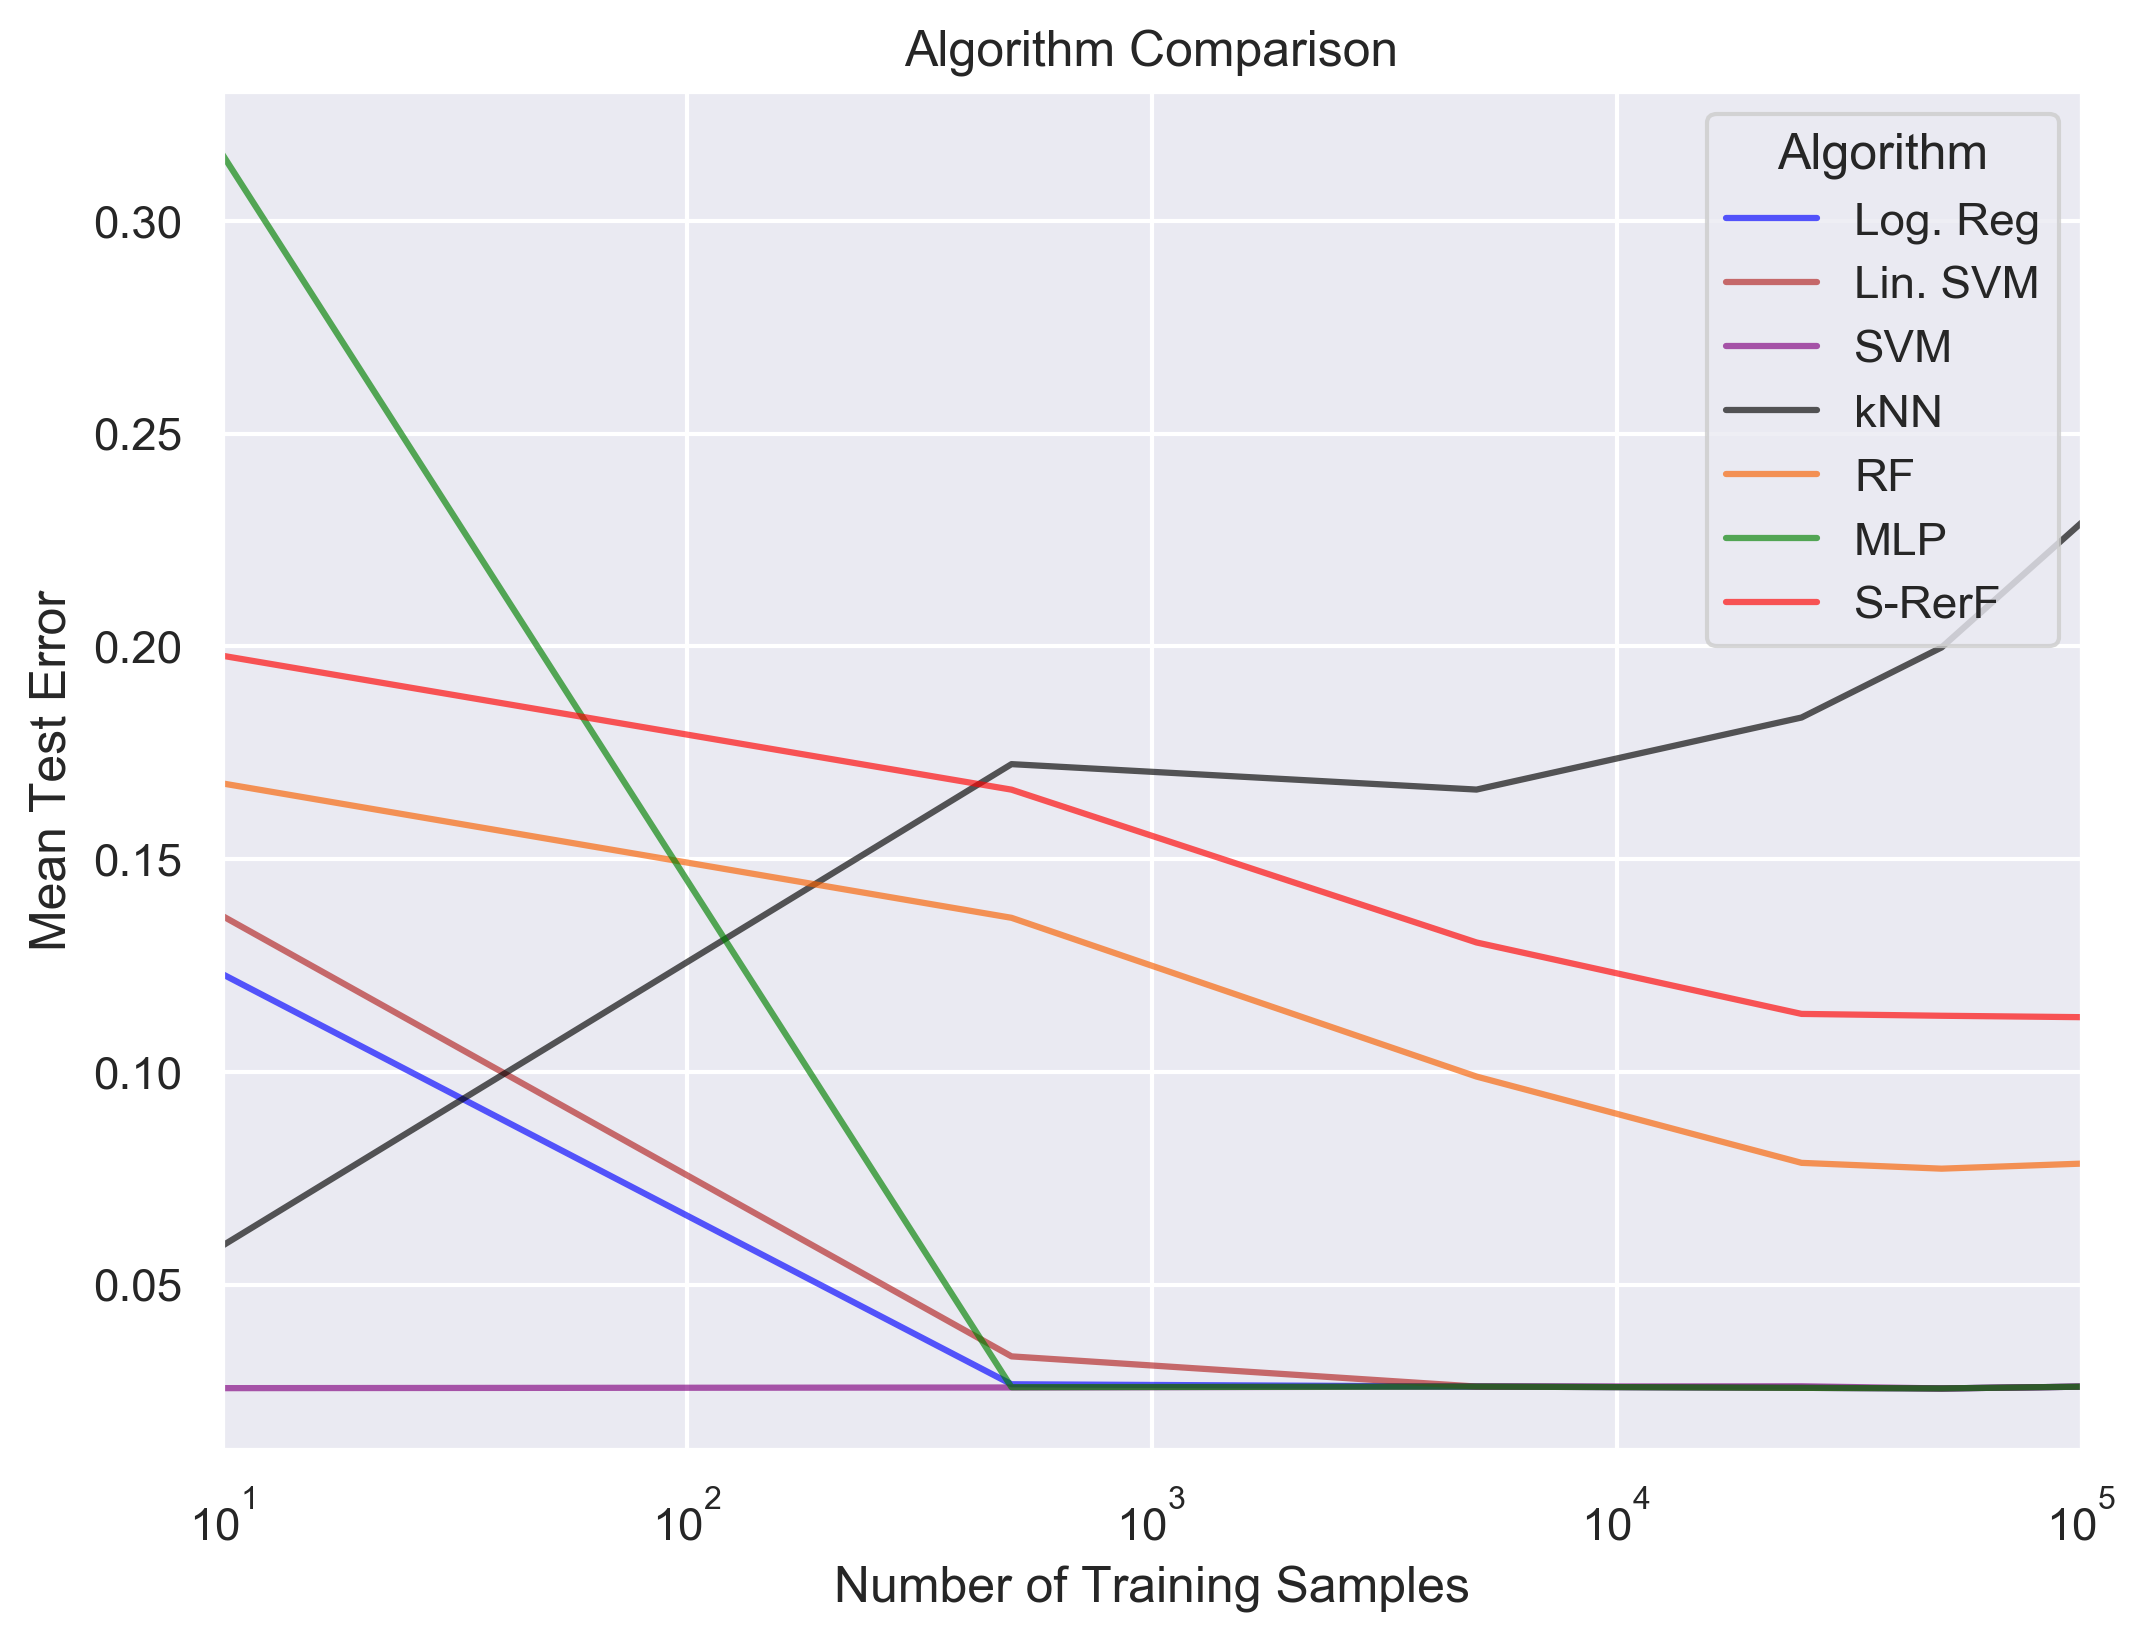

In [2]:
names = {"Log. Reg": "blue", "Lin. SVM":"firebrick", "SVM":"purple",
          "kNN": "black", "RF":"#f86000", "MLP":"green", "S-RerF":"red"}

## Read output file log and plot mean test error
dat = pd.read_csv("eeg_grasp_pre_lhat_onech_bin4.csv")

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]
        #print(tmp)
        se = stats.sem(tmp['Lhat'].astype(float))
        #print(tmp['Lhat'])

        list(tmp.mean())
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    ax.set_xscale('log')

plt.legend(loc='upper right',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Mean Test Error')
plt.xlabel('Number of Training Samples')
#plt.savefig('./s-rerf_circle_experiment.pdf',dpi=300,format='pdf')
plt.show()

Plotting average precison

c:\users\sanik\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Unrecognized location 'Upper right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


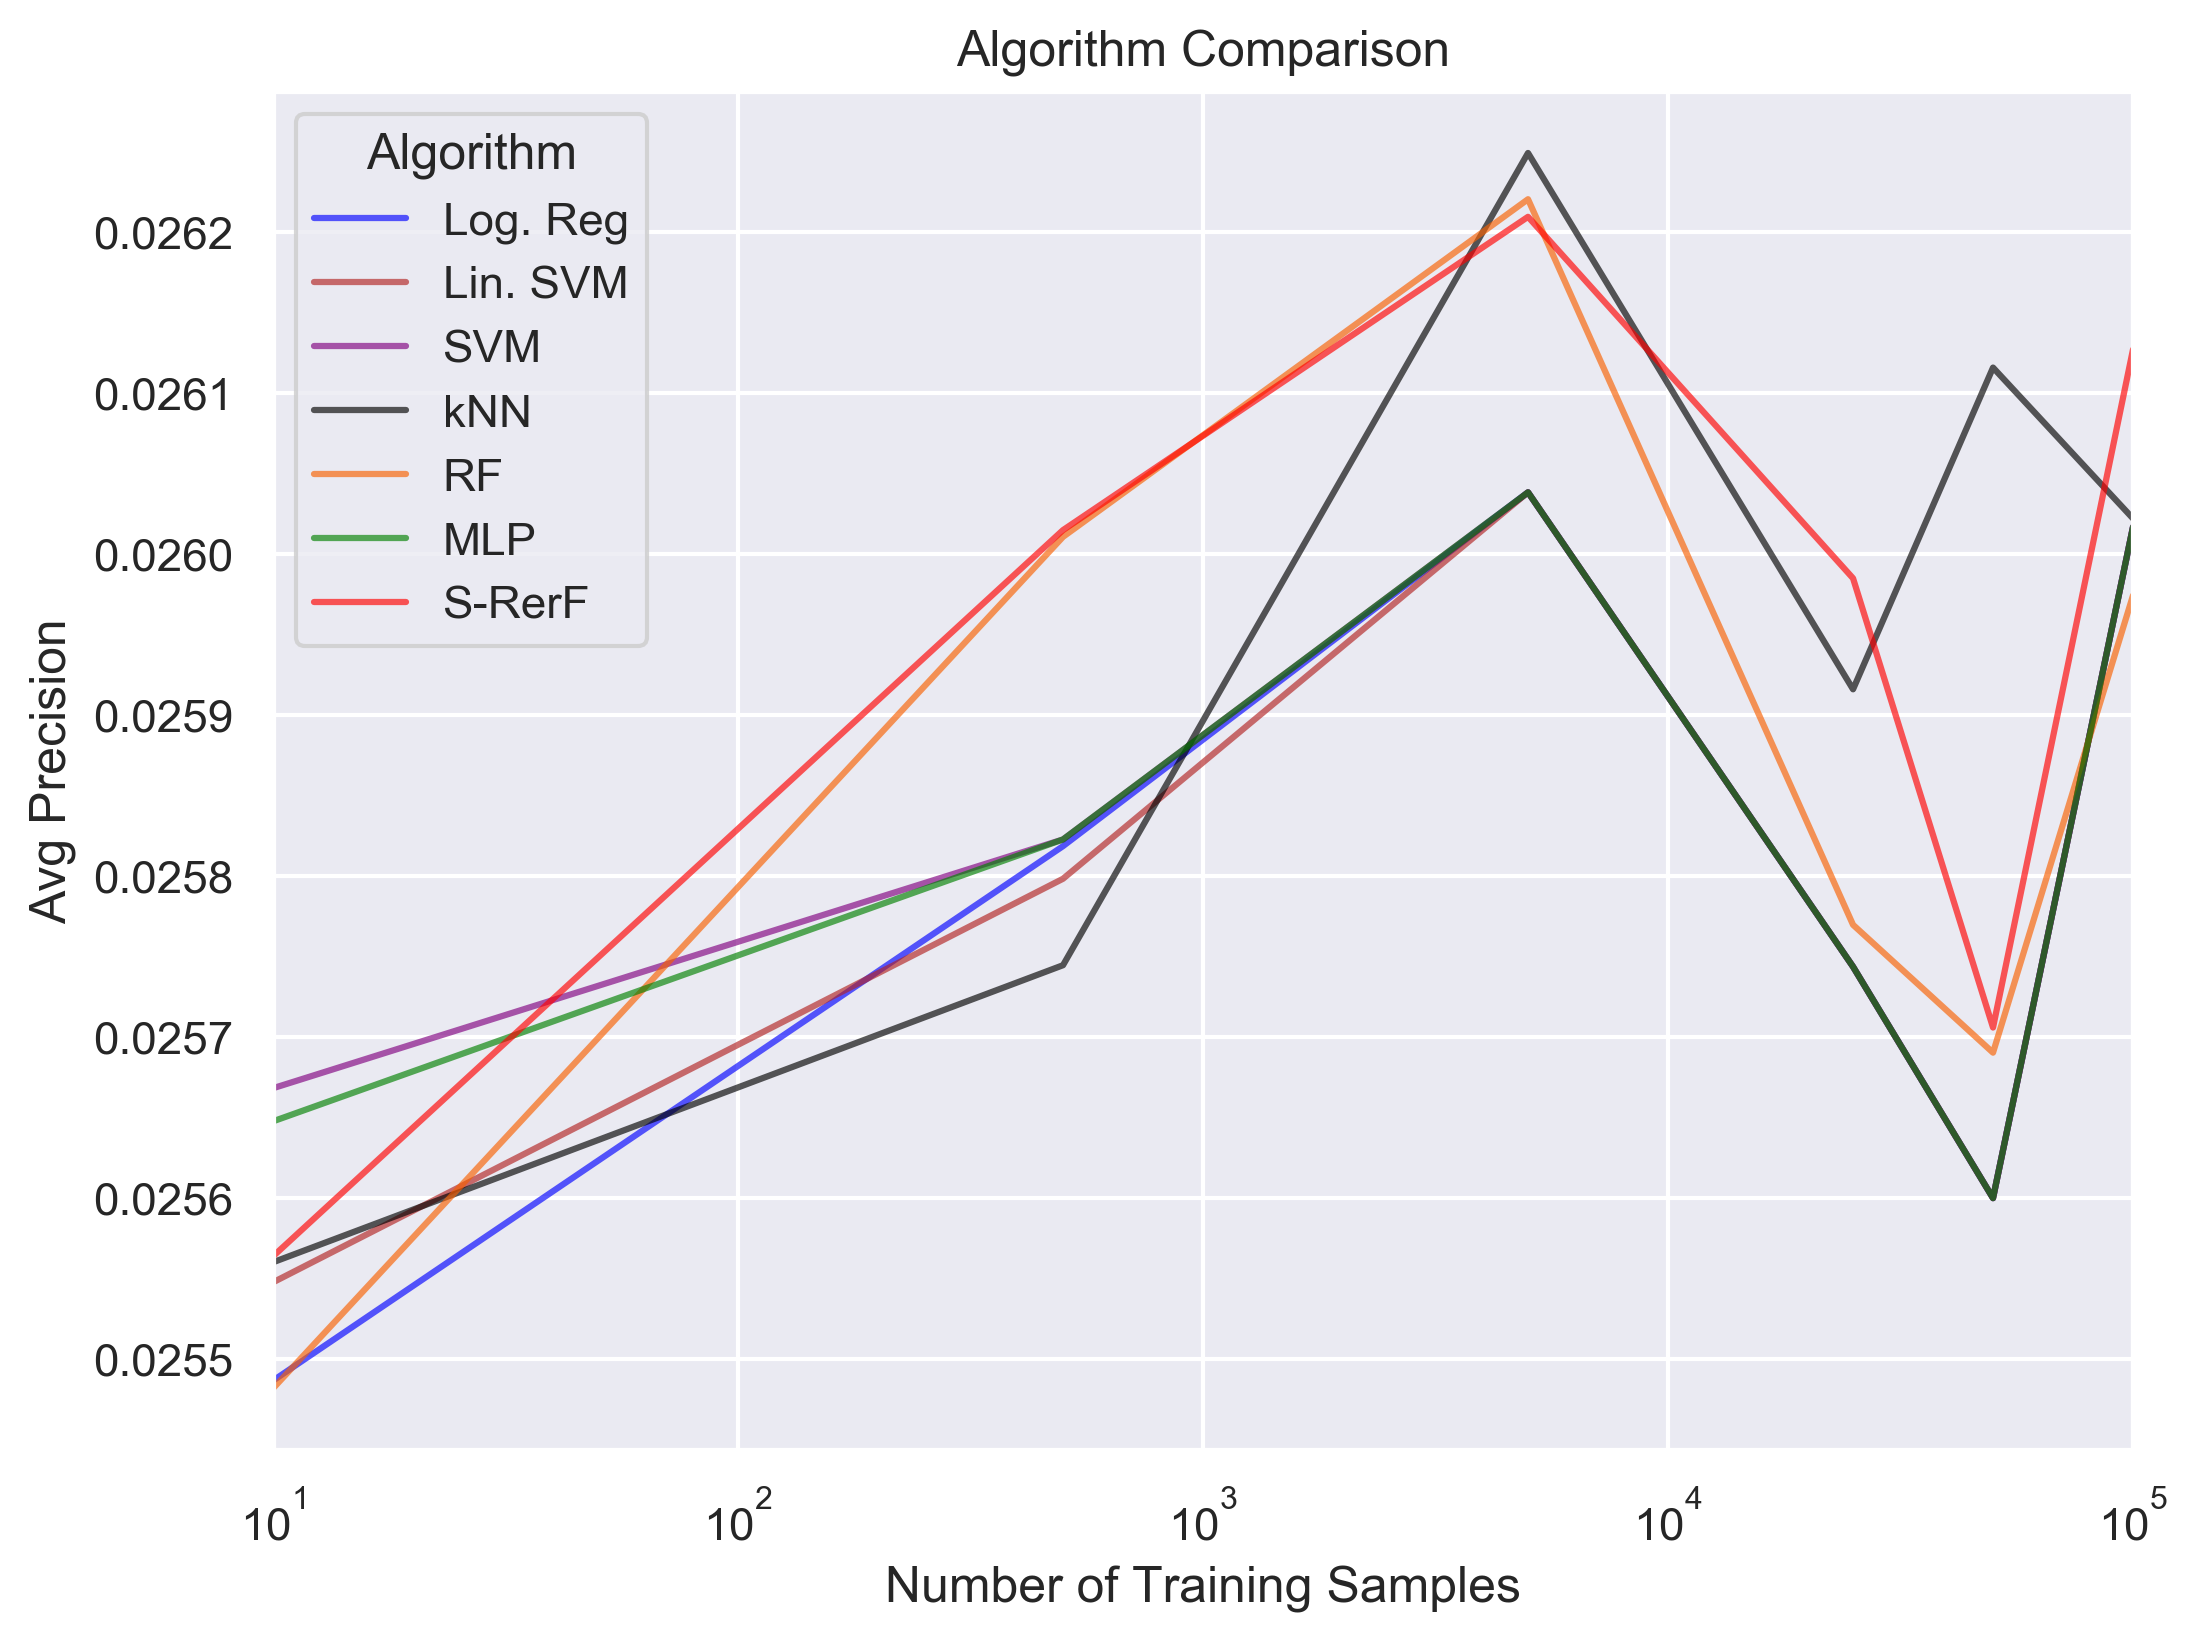

In [3]:
## Read output file log and plot average precision
dat = pd.read_csv("eeg_grasp_pre_lhat_onech_bin4.csv")

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Precision', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Precision']]
        #print(tmp)
        se = stats.sem(tmp['Precision'].astype(float))
        #print(tmp['Precision'])

        list(tmp.mean())
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Precision', label=key, \
            c = names[key], alpha =0.65)
    ax.set_xscale('log')

plt.legend(loc='Upper right',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Avg Precision')
plt.xlabel('Number of Training Samples')
#plt.savefig('./s-rerf_circle_experiment.pdf',dpi=300,format='pdf')
plt.show()